In [56]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

dataset_cleaned = pd.read_csv('dataset_cleaned.csv')
dataset_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
dataset_cleaned['TotalPrice'] = dataset_cleaned['Quantity'] * dataset_cleaned['UnitPrice']
current_date = dataset_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)


rfm = dataset_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days, # Recency (время с последней покупки)
    'InvoiceNo': 'nunique',                                 # Frequency (количество уникальных заказов)
    'TotalPrice': 'sum'                                     # Monetary (сумма всех покупок)
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1437.24
12349.0          19          1   1353.80
12350.0         310          1    294.40


In [19]:

rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=range(5, 0, -1))  # Чем меньше Recency, тем выше оценка
rfm['F_score'] = pd.cut(rfm['Frequency'], 5, labels=range(1, 6))    # Чем больше Frequency, тем выше оценка
rfm['M_score'] = pd.cut(rfm['Monetary'], 5, labels=range(1, 6))     # Чем больше Monetary, тем выше оценка


rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
print(rfm.head())



            Recency  Frequency  Monetary R_score F_score M_score RFM_Score
CustomerID                                                                
12346.0         326          1  77183.60       1       1       2       112
12347.0           2          7   4310.00       5       1       1       511
12348.0          75          4   1437.24       2       1       1       211
12349.0          19          1   1353.80       4       1       1       411
12350.0         310          1    294.40       1       1       1       111


In [23]:

best_customers = rfm[rfm['RFM_Score'] == '511']
print(best_customers)


Лучшие клиенты (RFM Score = 511):
            Recency  Frequency  Monetary R_score F_score M_score RFM_Score
CustomerID                                                                
12347.0           2          7   4310.00       5       1       1       511
12358.0           2          2    928.06       5       1       1       511
12362.0           3         10   4524.78       5       1       1       511
12364.0           8          4   1208.10       5       1       1       511
12367.0           4          1    150.90       5       1       1       511
...             ...        ...       ...     ...     ...     ...       ...
18245.0           7          7   2552.11       5       1       1       511
18272.0           3          6   3078.58       5       1       1       511
18273.0           2          3    204.00       5       1       1       511
18282.0           8          2    178.05       5       1       1       511
18283.0           4         16   2029.58       5       1       1  

In [32]:

at_risk_customers = rfm[rfm['R_score'] == '111']
print(at_risk_customers)

print(rfm['R_score'].value_counts())

rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

at_risk_customers = rfm[rfm['R_score'] == 1]
print(at_risk_customers)





Клиенты, которые могут уйти (R_score = 111):
Empty DataFrame
Columns: [Recency, Frequency, Monetary, R_score, F_score, M_score, RFM_Score]
Index: []
4    888
5    881
2    868
1    861
3    828
Name: R_score, dtype: int64
            Recency  Frequency  Monetary  R_score  F_score  M_score RFM_Score
CustomerID                                                                   
12346.0         326          1  77183.60        1        1        2       112
12350.0         310          1    294.40        1        1        1       111
12353.0         204          1     89.00        1        1        1       111
12354.0         232          1   1013.60        1        1        1       111
12355.0         214          1    459.40        1        1        1       111
...             ...        ...       ...      ...      ...      ...       ...
18239.0         219          5   1561.61        1        1        1       111
18250.0         310          1    349.27        1        1        1       11

In [36]:

rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)


loyal_customers = rfm[(rfm['F_score'] >= 3) & (rfm['M_score'] >= 3)]
print(loyal_customers)


Лояльные клиенты (высокие Frequency и Monetary):
            Recency  Frequency   Monetary  R_score  F_score  M_score RFM_Score
CustomerID                                                                    
14911.0           1        198  133125.48        5        5        3       553


In [53]:
def rfm_segment(row):
    if row['R_score'] <= 3 and row['Frequency'] >= 2 and row['Monetary'] >= 1000:
        return 'Best Customers'
    elif row['R_score'] >= 4:
        return 'At Risk'
    elif row['Frequency'] > 1 and row['Monetary'] >= 650:
        return 'Loyal Customers'
    else:
        return 'Other'


rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

segment_counts = rfm['Segment'].value_counts()

print(rfm.head())
print(segment_counts)


            Recency  Frequency  Monetary  R_score  F_score  M_score RFM_Score  \
CustomerID                                                                      
12346.0         326          1  77183.60        1        1        2       112   
12347.0           2          7   4310.00        5        1        1       511   
12348.0          75          4   1437.24        2        1        1       211   
12349.0          19          1   1353.80        4        1        1       411   
12350.0         310          1    294.40        1        1        1       111   

                   Segment  
CustomerID                  
12346.0              Other  
12347.0            At Risk  
12348.0     Best Customers  
12349.0            At Risk  
12350.0              Other  
Other              1769
At Risk            1769
Best Customers      538
Loyal Customers     250
Name: Segment, dtype: int64


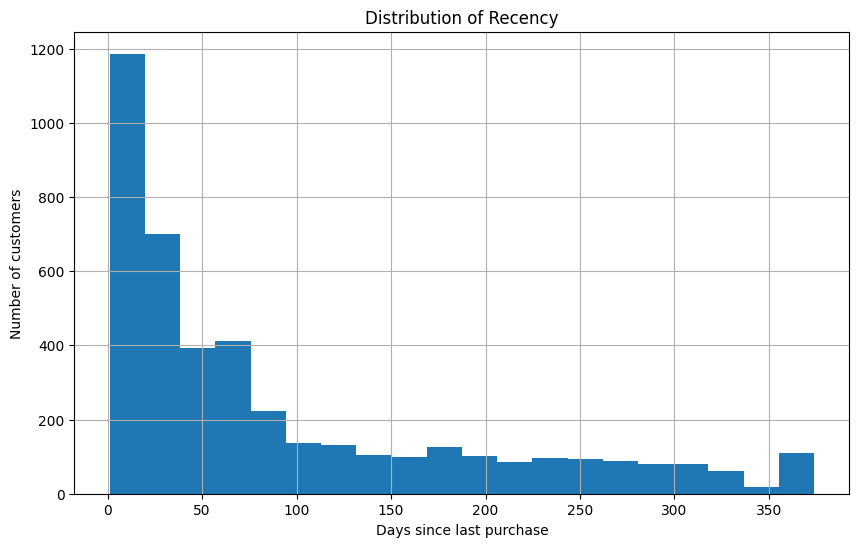

In [58]:
# Recency
plt.figure(figsize=(10, 6))
rfm['Recency'].hist(bins=20)
plt.title('Distribution of Recency')
plt.xlabel('Days since last purchase')
plt.ylabel('Number of customers')
plt.savefig('images/recency_distribution.png')
plt.show()

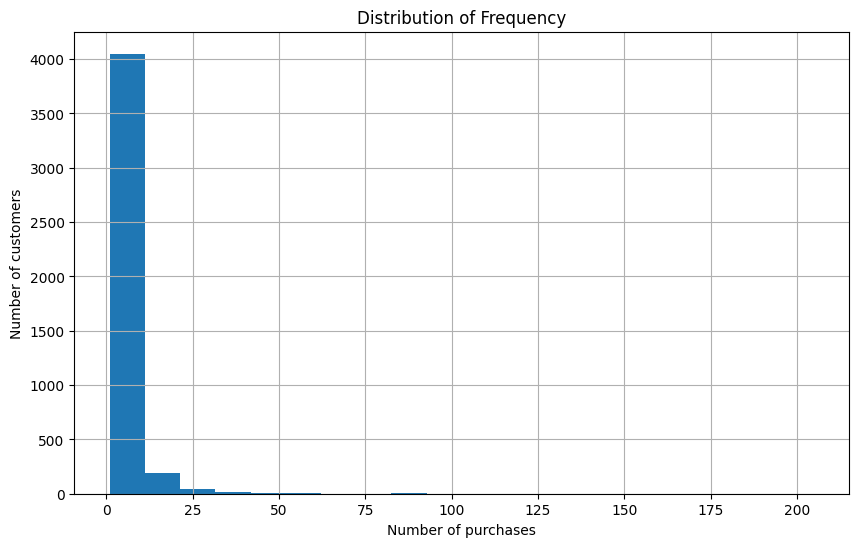

In [59]:
# Frequency
plt.figure(figsize=(10, 6))
rfm['Frequency'].hist(bins=20)
plt.title('Distribution of Frequency')
plt.xlabel('Number of purchases')
plt.ylabel('Number of customers')
plt.savefig('images/frequency_distribution.png')
plt.show()

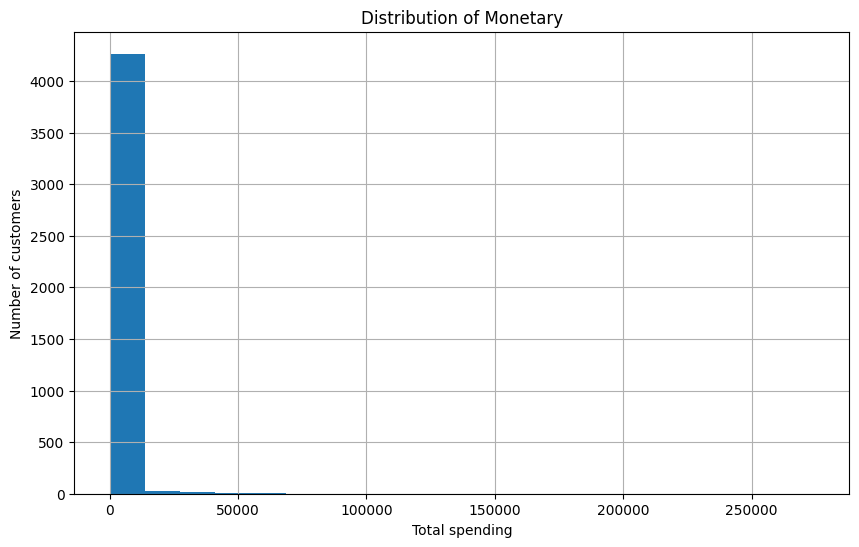

In [60]:
# Monetary
plt.figure(figsize=(10, 6))
rfm['Monetary'].hist(bins=20)
plt.title('Distribution of Monetary')
plt.xlabel('Total spending')
plt.ylabel('Number of customers')
plt.savefig('images/monetary_distribution.png')
plt.show()

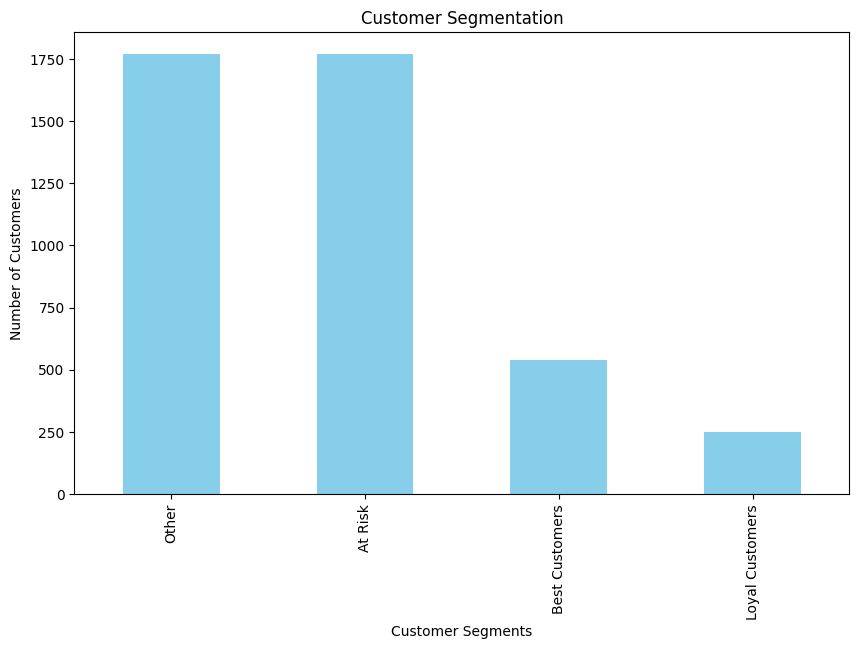

In [61]:
# Segmentation
plt.figure(figsize=(10, 6))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Segmentation')
plt.xlabel('Customer Segments')
plt.ylabel('Number of Customers')
plt.savefig('images/customer_segmentation.png')
plt.show()